In [145]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import ast
from sklearn.linear_model import LinearRegression
import datetime as dt

# **STEP 0: Data opening and preprocessing**

The data in the CMU Movie Summary Corpus contains a collection of 42,306 movie plot summaries and metadata at both the movie level (including box office revenues, genre and date of release) and character level (including gender and estimated age):

**Data:**
1. `plot_summaries.txt.gz` [29 M]: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.
2. `corenlp_plot_summaries.tar.gz` [628 M, separate download]: to downlaod if considered useful... The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

**Metadata:**
1. `movie.metadata.tsv.gz` [3.4 M]: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)
2. `character.metadata.tsv.gz` [14 M]: Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

**Test data**:
1. `tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
2. `name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types. The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

### Data loading and pre-processing

In [146]:
data_folder = './MovieSummaries/'
characters = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)
movies = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t', header=None)
character_types = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', header=None)
name_clusters = pd.read_csv(data_folder + 'name.clusters.txt', sep='\t', header=None)

In [147]:
characters.columns =['Wikipedia_movie_ID', 
                     'Freebase_movie_ID', 
                     'Movie_release_date', 
                     'Character_name', 
                     'Actor_birth', 
                     'Actor_Gender', 
                     'Actor Height', 
                     'Actor_Ethnicity', 
                     'Actor_Name', 
                     'Age_at_movie_release', 
                     'Freebase_character_actor_map_ID', 
                     'Freebase_character_ID', 
                     'Freebase_actor_ID']

movies.columns =['Wikipedia_movie_ID', 
                 'Freebase_movie_ID', 
                 'Name',
                 'Release_date', 
                 'Box_office_revenue', 
                 'Runtime',
                 'Languages', 
                 'Countries', 
                 'Genres']

plot_summaries.columns =['Wikipedia_movie_ID', 'Summary']
character_types.columns =['Type', 'Info']
name_clusters.columns =['Character_name', 'Freebase_character_actor_map_ID']

clean date:

In [148]:
movies.Release_date.iloc[62836] =  pd.to_datetime('2010-12-02') 
movies['Release_date'] = pd.to_datetime(movies['Release_date'])

C:\Users\Nate\AppData\Local\Temp\ipykernel_16812\2605603465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.Release_date.iloc[62836] =  pd.to_datetime('2010-12-02')


lets get the information about the ethnicity via wikipedia


In [149]:
ethnicity_id = list(characters['Actor_Ethnicity'].value_counts().index)
for e in ethnicity_id : print('"'+e+'"',end=' ')

"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m

In [150]:
#pip install sparqlwrapper
#https://rdflib.github.io/sparqlwrapper/

endpoint_url = "https://query.wikidata.org/sparql"

query1 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/044038p" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m/02jvpv" "/m/0dbxy" "/m/02vsw1" "/m/08cjt2" "/m/013s3n" "/m/09zyn5" "/m/0cm7w1" "/m/04q7gbh" "/m/0fj1k9" "/m/0fqp6zk" "/m/04f581" "/m/012c1l" "/m/071x0k" "/m/0ffjqy" "/m/0ffkb4" "/m/0g5y6" "/m/0bzkm2" "/m/0dllcfn" "/m/04y8_bm" "/m/03gskx0" "/m/0268d21" "/m/019lrz" "/m/02p4q5p" "/m/04czx7" "/m/02p656s" "/m/0ffhz3" "/m/04jq32s" "/m/04mmhj" "/m/0dj8k3" "/m/059_w" "/m/01kg2v" "/m/0222hg" "/m/0f0gt_" "/m/01j2qv" "/m/0ffjvd" "/m/032j30" "/m/033njm" "/m/0bs7l_v" "/m/0g48m4" "/m/022fdt" "/m/052r3t" "/m/0bfjm7" "/m/01xttr" "/m/04ydrsn" "/m/03295l" "/m/06lshc" "/m/03cbkrf" "/m/0283js_" "/m/09cqth" "/m/04nrnz" "/m/05748" "/m/025_0f0" "/m/01trsl" "/m/09vmyh" "/m/05sf2x" "/m/09gk_6h" "/m/078vc" "/m/01p7s6" "/m/017sq0" "/m/018s6c" "/m/04y29" "/m/067lts" "/m/05g0f1" "/m/0761bp" "/m/09gp4" "/m/02qv_h_" "/m/0640_7q" "/m/0912ll" "/m/013b7g" "/m/067lrj" "/m/0b79c7" "/m/09lz9zx" "/m/01swvz" "/m/01nbcy" "/m/0b0gzf" "/m/071drf" "/m/027vy0s" "/m/0150zs" "/m/0278pqj" "/m/0747611" "/m/0c2hxm" "/m/0462jl6" "/m/074w_m" "/m/04ggbzy" "/m/0hbz9xw" "/m/0152s7" "/m/0fng3k" "/m/0j4w_" "/m/0b98sy" "/m/08v2k7" "/m/0j6x8" "/m/0d9q7j" "/m/016f5d" "/m/0ffj5g" "/m/0338zd" "/m/04_tz7" "/m/027lf0d" "/m/0ch3pqf" "/m/06fczy" "/m/01mw1s" "/m/04608z" "/m/04_hr_" "/m/026cybk" "/m/01hwt" "/m/08gzsf" "/m/05vhv7" "/m/04_bc8" "/m/06rd7" "/m/0318mh" "/m/02wcbj_" "/m/0520604" "/m/07j80c" "/m/078ds" "/m/0fk1z" "/m/0dv5vw" "/m/04znbg" "/m/01sq7s" "/m/0gf5k1" "/m/03pqwy" "/m/031_sd" "/m/012f86" "/m/092h2qt" "/m/033qxt" "/m/03vghh" "/m/0bjbszh" "/m/07hyjp" "/m/03yk6g" "/m/0h1nk0k" "/m/04zjjt" "/m/02czfr" "/m/05qb937" "/m/047l_90" "/m/0bnzjx" "/m/02q206y" "/m/0665pp" "/m/07gzw5" "/m/062_25" "/m/0hj35" "/m/0bh91q8" "/m/01g0y_" "/m/07lv5x" "/m/0g4pffv" "/m/0828vj" "/m/07d_p8" "/m/04lhn7b" "/m/0fq6zlv" "/m/0268pvf" "/m/0466nw8" "/m/04pnf" "/m/02p_gby" "/m/06k6sl" "/m/0738n4" "/m/0266mf0" "/m/0cx3p" "/m/04kbvpz" "/m/07s9g04" "/m/04l_pt" "/m/026c9dq" "/m/01ylpf" "/m/0g5k7qv" "/m/01tyl3" "/m/0b__fv3" "/m/02vkd28" "/m/013s41" "/m/047948f" "/m/067lwk" "/m/03d19xz" "/m/02gx2x" "/m/021pd" "/m/013s2p" "/m/09fqz7" "/m/0ffhvl" "/m/075dhf0" "/m/02dd5z" "/m/03wbmrc" "/m/0br_8h" "/m/097nms" "/m/02cm28" "/m/0h6mqq9" "/m/09tqq8q" "/m/0301y_" "/m/0d8qh0" "/m/03h1dq9" "/m/03fk0c" "/m/026kx7g" "/m/04k02l" "/m/051wcch" "/m/026zlyd" "/m/01n94b" "/m/04dzwby" "/m/0btrm4" "/m/03ndvw" "/m/0fxmtg" "/m/04sfz4s" "/m/03cnzsg" "/m/03r_k" "/m/03f3sf" "/m/04lfc70" "/m/02vkw95" "/m/09y7x4" "/m/0fk3s" "/m/0h8mzsl" "/m/02p444n" "/m/03kbr" "/m/0bns36b" "/m/0bbcnlt" "/m/046j25" "/m/0dq1q" "/m/02rdfpy" "/m/05c60ml" "/m/0470lk" "/m/02p7gyv" "/m/0c29q8" "/m/03ck8x1" "/m/042199j" "/m/0bms44" "/m/01nft3" "/m/01d7kx" "/m/01c034" "/m/05cc9h" "/m/03cl2pz" "/m/03x_lpj" "/m/02rp50t" "/m/03m3p6w" "/m/02r_qms" "/m/086wp0" "/m/065z7w_" "/m/01f9bg" "/m/03sx6v" "/m/034s7b" "/m/0987ctr" "/m/03gy1h2" "/m/0c_lbq" "/m/03ftx7" "/m/067lv3" "/m/0g44f5" "/m/03d26m9" "/m/0165md" "/m/0dqrh8" "/m/0cc5y74" "/m/0289z8v" "/m/01267" "/m/0fpjs3j" "/m/03cdk7b" "/m/0bfrrj" "/m/04wy6k" "/m/03zcwh" "/m/0dc58y8" "/m/0g5rkt4" "/m/0647lm" "/m/04fh1b" "/m/047bp1r" "/m/09cd0m" "/m/03fvrb" "/m/025x6k1" "/m/02rm7_9" "/m/01l0ty" "/m/07s49c2" "/m/03ty8_" "/m/02m0kh" "/m/05ms3p0" "/m/0gtwjz6" "/m/0ftlzz" "/m/02pzb09" "/m/05sycg" "/m/051x6yk" "/m/01vsch" "/m/04csgrq" "/m/064b9n" "/m/09chmw" "/m/095mw2" "/m/09snp5" "/m/025tvhm" "/m/0c41n" "/m/01_5cg" "/m/025xss1" "/m/0404kdr" "/m/0ftwg" "/m/0790v" "/m/02r3wfk" "/m/03h11s3" "/m/01vr3v" "/m/0c3wsgg" "/m/06y24j" "/m/0ckk60" "/m/03lnnd" "/m/04hlx1" "/m/062zk4r" "/m/097r55" "/m/0b8yvr" "/m/0br_9j" "/m/0xff" "/m/01crfj" "/m/05mtdy" "/m/065577s" "/m/0fp4n" "/m/0301xt" "/m/01kb9y" "/m/0268xtg" "/m/05y2yj" "/m/0ffk5n" "/m/02vys3l" "/m/01h4n" "/m/0bvnws" "/m/06dy2k" "/m/08yg47" "/m/08c25t" "/m/0bvjpj" "/m/03x1x" "/m/0dn1_0" "/m/02qv716" "/m/02r11hz" "/m/06bkf" "/m/035b50" "/m/0166vx" "/m/01g3rx" "/m/06w4lv" "/m/04wysy" "/m/064pj" "/m/013z8m" "/m/04118b" "/m/064rb5l" "/m/01ywdy" "/m/01flqq" "/m/0960kn" "/m/0180zw" "/m/0463n9y" "/m/0d32d1" "/m/07n8wy" "/m/03q819" "/m/06vb7b" "/m/02pj9yr" "/m/03hf_6z" "/m/01km_m" "/m/062szv5" "/m/07g8yp" "/m/0fk55" "/m/04lgl9t" "/m/0444sm4" "/m/03m9my8" "/m/03cjjy0" "/m/03cmqbt" "/m/0b3zsn" "/m/03b_13l" "/m/0152wh" "/m/05ysft4" "/m/05sng" "/m/059v8" "/m/09c8kp" "/m/04jtjvt" "/m/04c28" "/m/03sk2" "/m/05ztd1" "/m/0dm3xpw" "/m/03hjx6f" "/m/026d074" "/m/03nvq" "/m/03nz70" "/m/029q52" "/m/02wz7j" "/m/04kdwcx" "/m/02ry8mk" "/m/07wsyr" "/m/09r2kh" "/m/04_8lfc" "/m/033qt1" "/m/012fh" "/m/08j1fb" "/m/027936c" "/m/0dtkkb" "/m/05bzpzx" "/m/04lhnps" "/m/0fp54b" "/m/01hm_" "/m/0288fw3" "/m/0ft9bs" "/m/01gr8h" "/m/09g34_" "/m/0d8qls" "/m/08xbxs" "/m/032m0b" "/m/04hqxn" "/m/068y7m" "/m/044bp_" "/m/039z49" "/m/047q05d" "/m/0c50f" "/m/01srl7" "/m/0fpxlz9" "/m/0bdynxs" "/m/01gby2" "/m/043_z22" "/m/03x_fq7" "/m/01hphz" "/m/033fjj" "/m/013y54"}.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

query2 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" }.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results1 = get_results(endpoint_url, query1)
results2 = get_results(endpoint_url, query2)

In [151]:
for result in results1["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

for result in results2["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)
characters.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


Let's clean the `movies` dataframe to remove the language, country and genre indices in front of each value using the regex `re` library. We can also create lists of genres for each movie instead of a long string in the `Genres` column. This pre-processing is done below.

In [152]:
movies[['Genres']] = movies[['Genres']].applymap(ast.literal_eval)

def replace_dicts(arg):
    return list(arg.values())

movies[['Genres']] = movies[['Genres']].applymap(replace_dicts)

In [153]:
movies['Languages'] = movies['Languages'].apply(lambda x: re.findall('": "(.*)"', x)).str[0]
movies['Countries'] = movies['Countries'].apply(lambda x: re.findall('": "(.*)"', x)).str[0]

In the `character_types` dataframe above, the `Info` column contains long strings that give information about the character that the character type describes, the movie in which the character is found, the Freebase character/actor map ID and the actor that embodies the character. All of this information can be separated into four disctint columns: character, movie, ID and actor columns, using the `json` library as below. 

In [154]:
character_types[['char', 'movie', 'Freebase_character_actor_map_ID', 'actor']] = character_types['Info'].apply(lambda x: json.loads(x)).apply(pd.Series)
character_types.drop('Info', axis=1, inplace=True)


In [155]:
print(f'Movies dataframe has {len(movies)} rows')
print(f'Characters dataframe has {len(characters)} rows')
print(f'Plot_summaries dataframe has {len(plot_summaries)} rows')
print(f'Character_types dataframe has {len(character_types)} rows')
print(f'Name_clusters dataframe has {len(name_clusters)} rows')

Movies dataframe has 81741 rows
Characters dataframe has 450669 rows
Plot_summaries dataframe has 42303 rows
Character_types dataframe has 501 rows
Name_clusters dataframe has 2666 rows


Therefore, each of our da

*A voir si c'est utile d'ajouter les plots directement au movie dataset...*

In [156]:
movies_plot = movies.merge(plot_summaries, on="Wikipedia_movie_ID")


Some data combination

In [157]:
merge_characters_type = pd.merge(characters, character_types, on='Freebase_character_actor_map_ID', suffixes=('', '_y'))


In [158]:
merge_characters_type.drop(['char','actor'],axis=1, inplace=True)


In [159]:
merge_characters_type = pd.merge(merge_characters_type, movies[['Wikipedia_movie_ID', 'Languages', 'Countries', 'Genres', 'Box_office_revenue', 'Runtime']], on='Wikipedia_movie_ID', suffixes=('', '_y'))


# **STEP 1: dictionnary definitions**

Trick: could add spaces in front of words that are ambiguous. Example below with SS: a lot of words contain the sequence ss, but space+ss is rare. We could even consider space+ss++space, but this would exclude some occurances due to punctuation.

### World War 2

In [160]:
WW2 =  ['Allies','Auschwitz','Bombardment', 'battleship', 'Bailey bridge', 'Blitzkrieg','Churchill','D-Day',' ss'
        'Dunkirk', 'Doolittle', 'de Gaulle','English Channel', 'Eisenhower','Enigma','flying tigers', 'free french',
        'nazi','helmet','Hiroshima','Invasion','Luftwaffe','Manhattan Project', 'Midway','Pearl harbor','Normandy', 'Nagasaki',
        'Panzer','Roosevelt', 'Rangers','Resistance','Truman', 'Stalin', 'tank','Victory', 'V-1 rocket','doodlebugs',
        'World War II','ww2','Hitler','air raid','shelter','siren','Battle of Britain','evacuee','evacuation','gas mask',
        'spitfire']
WW2 = [x.lower() for x in WW2]

### Space race

In [161]:
Space = ['aeronautics','Alan Shepard','Apollo','Cape Canaveral','capitalism','Cold War','Communism','Gemini','heat shields', 
         'Houston','John Glenn','Laika','launch','Lunar Module','Mercury','Michael Collins','Mission Control','NASA','neil Armstrong',
         'orbit','planet','rocket','satellite','Scott Carpenter','Sergei Korolev','solar system','space','space exploration','Space Race',
         'Sputnik','superpowers','test pilot',' USA',' URSS','Yuri Gagarin']
Space = [x.lower() for x in Space]

### Metric

If we do number of words, it could depend too much on the length of the plot summary or the length and quality of the dictionnary. Thus, a min-max scaling or standardization could be usefull afterward in the feature space. 

# **STEP 2: Apply dictionnaries to plot summaries to create new features**

lower case every plot summary:

In [162]:
summaries = movies_plot.Summary.apply(lambda h: h.lower())

Count the number of times word from a given dictionnary occurs in a plot summary. This function creates a new column in the movies_plot DF.

In [163]:
def count_dict(name,dictionnary):
    movies_plot[name] = summaries.apply(lambda summary: np.sum([summary.count(word) for word in dictionnary]))
                                          

In [164]:
count_dict('WW2',WW2)
count_dict('SpaceRace',Space)

In [165]:
len(movies_plot[movies_plot.WW2 > 10])

60

In [166]:
movies_plot.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,WW2,SpaceRace
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",0,1
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,English Language,United Kingdom,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,0,1
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,German Language,Germany,[Drama],"Eva, an upper class housewife, becomes frustra...",0,0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,English Language,South Africa,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",0,0
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,English Language,United States of America,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",0,0


# **STEP 2: ANALYSIS**

In [167]:
#temporary tresholds:
ww2T = 5
SpaceT = 5

## w.r.t time

In [168]:
def time_analysis(name,tresh,freq = '5y'):
    analysis = movies_plot[movies_plot[name] > tresh].copy()
    
    analysis = analysis.groupby(pd.to_datetime(analysis['Release_date']).dt.to_period(freq = freq)).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'number': x[name].count(),
            'mean_revenue' : x['Box_office_revenue'].mean(),
            'mean_runtime' : x['Runtime'].mean(),
        })
    )
    return analysis

#See how to plot better
def plot_time_analysis(time_analysis,name):
    time = time_analysis.index.to_timestamp()
    for analysis in time_analysis.columns:
        #plt.plot(time,reg.predict(x),'k-',label = f'{round(reg.coef_[0],4)} year + {round(reg.intercept_,2)}')
        plt.plot(time,time_analysis[analysis],'.',label = analysis)
        plt.legend()
        plt.xlabel('time [year]')
        plt.title(analysis+' for '+name)
        plt.show()
    

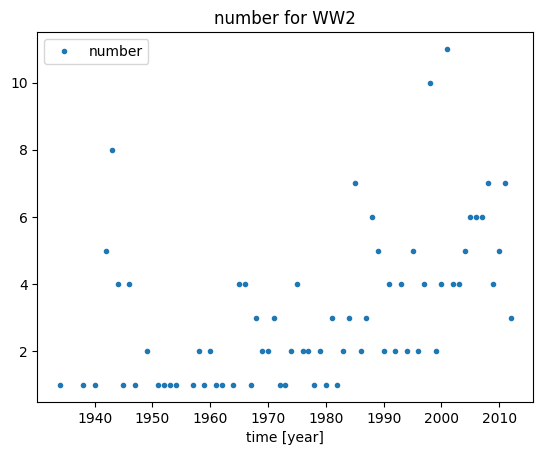

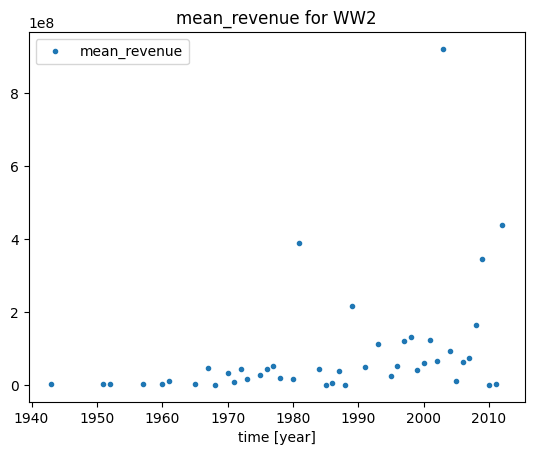

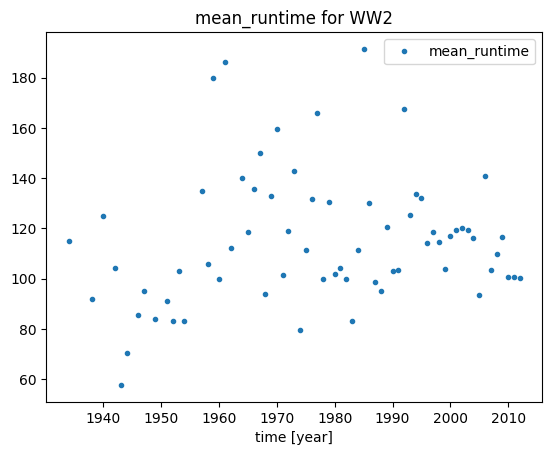

In [169]:
WW2_analysis = time_analysis('WW2',ww2T)
plot_time_analysis(WW2_analysis,'WW2')

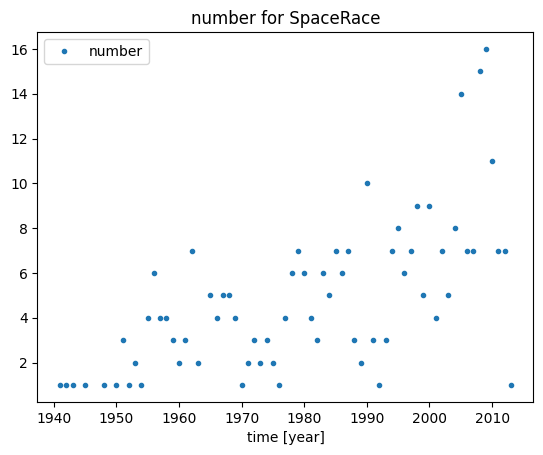

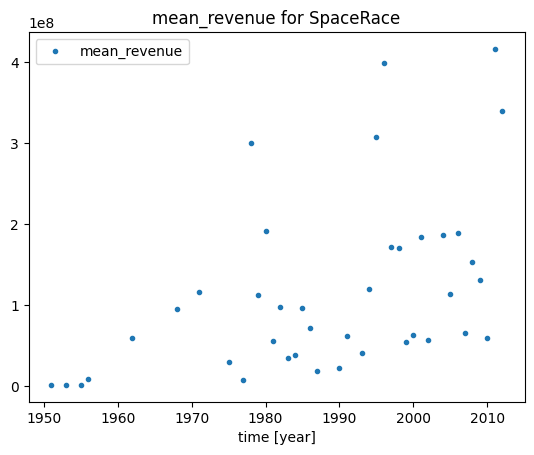

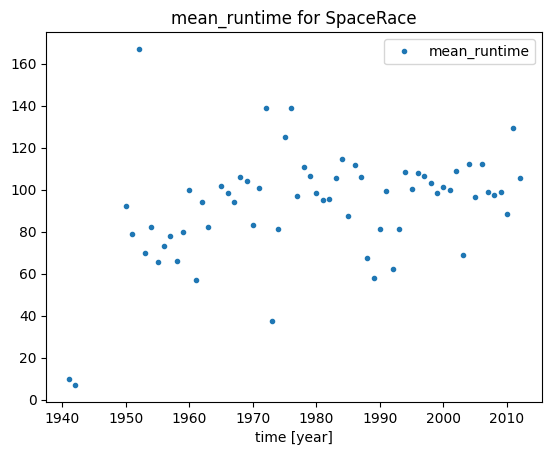

In [170]:
Space_analysis = time_analysis('SpaceRace',SpaceT)
plot_time_analysis(Space_analysis,'SpaceRace')

### Observe distribution

In [ ]:
def plot_distr():
    

In [191]:
WW2_time_dist.Release_date.value_counts()

2001    11
1998    10
1943     8
1985     7
2011     7
        ..
1938     1
1957     1
1945     1
1973     1
1954     1
Freq: 5A-DEC, Name: Release_date, Length: 69, dtype: int64

C:\Users\Nate\AppData\Local\Temp\ipykernel_16812\488509067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW2_time_dist['Release_date'] = pd.to_datetime(WW2_time_dist['Release_date']).dt.to_period(freq = '5Y')


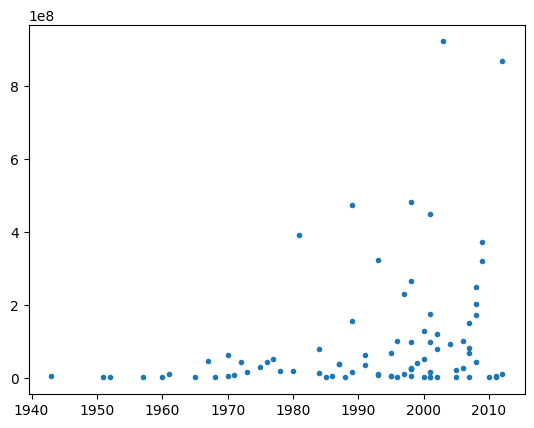

In [192]:
WW2_time_dist = movies_plot[movies_plot.WW2 > ww2T]
WW2_time_dist['Release_date'] = pd.to_datetime(WW2_time_dist['Release_date']).dt.to_period(freq = '5Y')

#time = WW2_time_dist['Release_date'].to_timestamp()
plt.plot(WW2_time_dist['Release_date'].dt.to_timestamp(),WW2_time_dist['Box_office_revenue'],'.') 

#WW2_time_dist['Release_date']
#WW2_time_dist

# Some vizualisation (Nono's excellent code)

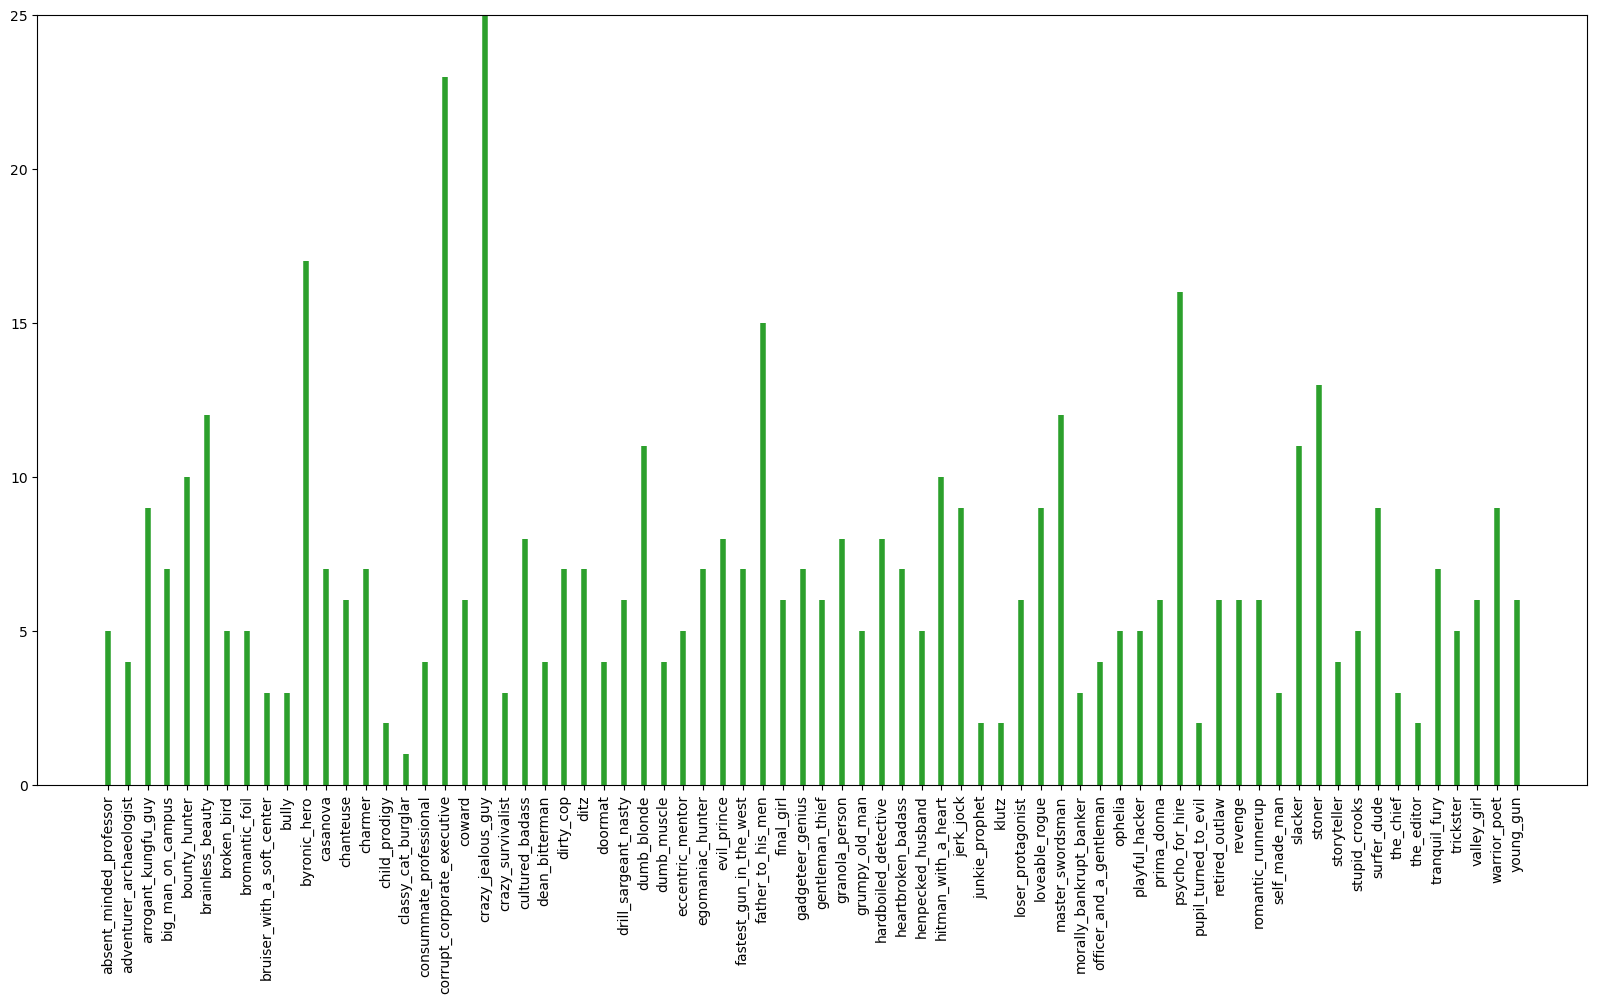

In [21]:
values = []
counts = []
for v,c in merge_characters_type.groupby(by='Type') :
    values += [v]
    counts += [len(c)]
plt.figure(figsize=(20,10))
plt.vlines(values, 0, counts, color='C2', lw=4)
plt.ylim(0,max(counts))
plt.xticks(rotation='vertical')
plt.show()

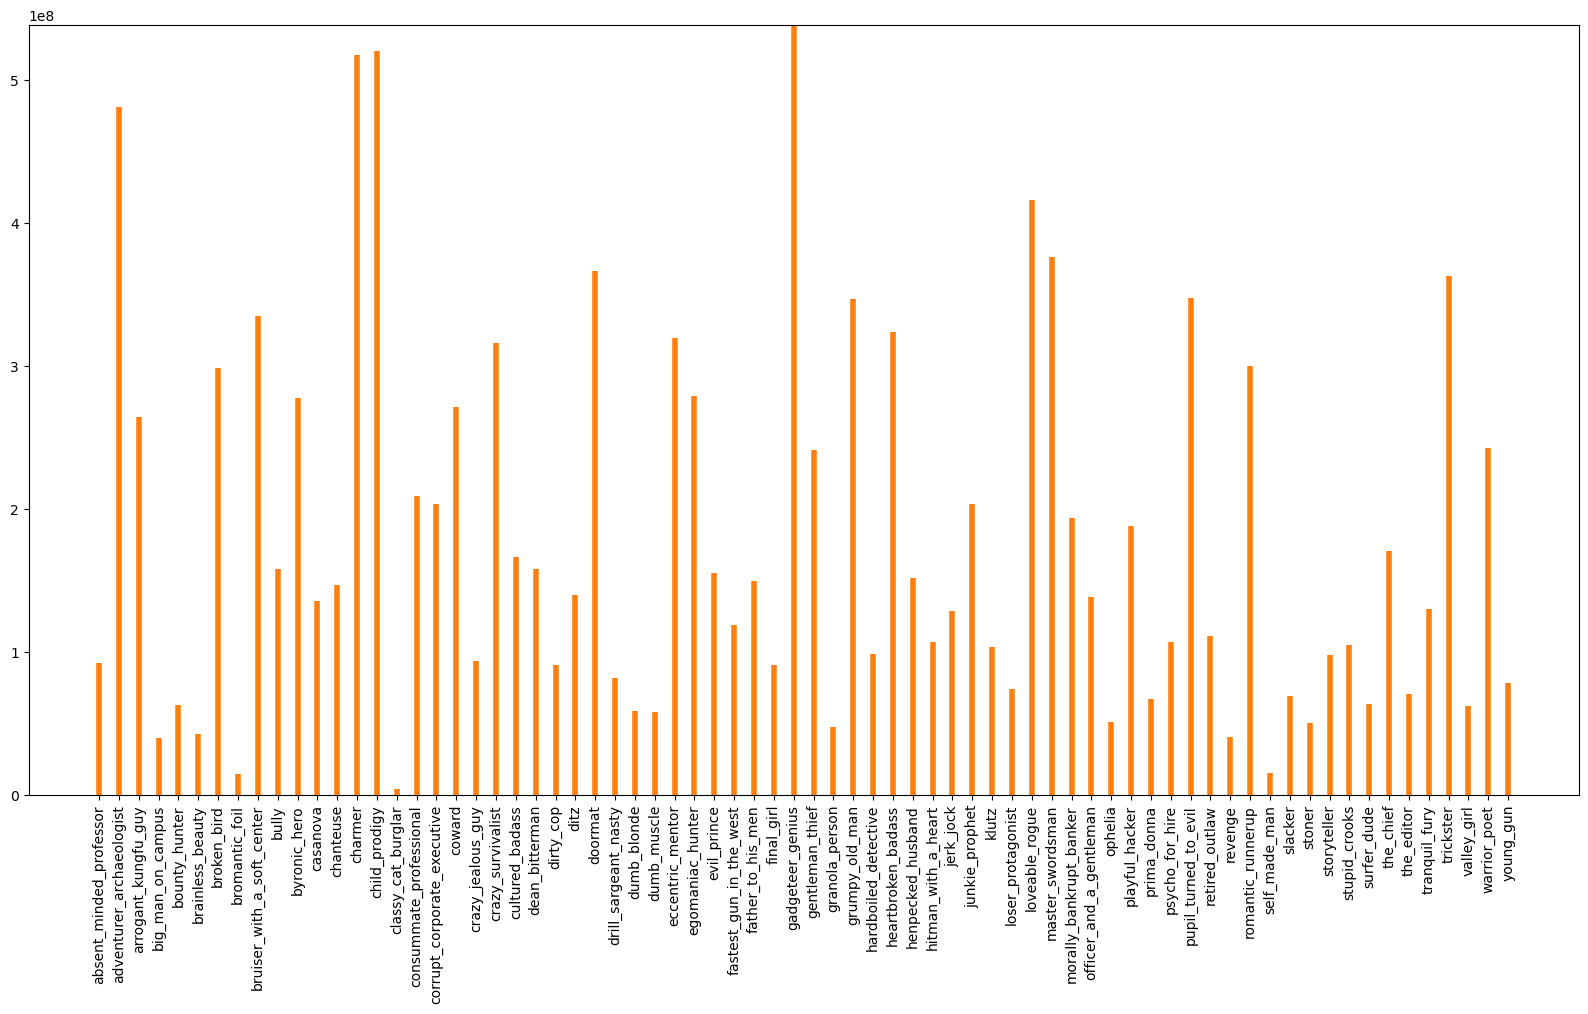

In [26]:
values = []
counts = []
for v,c in merge_characters_type.groupby(by='Type') :
    values += [v]
    counts += [c.Box_office_revenue.mean()]
plt.figure(figsize=(20,10))
plt.vlines(values, 0, counts, color='C1', lw=4)
plt.ylim(0,max(counts))
plt.xticks(rotation='vertical')
plt.show()

In [27]:
merge_characters_type.Type.value_counts()

crazy_jealous_guy              25
corrupt_corporate_executive    23
byronic_hero                   17
psycho_for_hire                16
father_to_his_men              15
                               ..
pupil_turned_to_evil            2
the_editor                      2
junkie_prophet                  2
child_prodigy                   2
classy_cat_burglar              1
Name: Type, Length: 72, dtype: int64

look for the crazy jalouse guy

In [28]:
Crazy_jalouse_guy = merge_characters_type.loc[merge_characters_type['Type'].isin(['crazy_jealous_guy'])]
Crazy_jalouse_guy.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Type,movie,Languages,Countries,Genres,Box_office_revenue,Runtime
7,142457,/m/011yqc,1997-05-14,Bud White,1964-04-07,M,1.80,Māori,Russell Crowe,33.0,/m/0j_n0t,/m/02h75l1,/m/06dv3,crazy_jealous_guy,L.A. Confidential,English Language,United States of America,"[Thriller, Mystery, Crime Fiction, Drama]",126216940.0,136.0
20,1094719,/m/045j3w,2004-10-22,Takeo,1960-04-02,M,NaN,NaN,Takashi Matsuyama,44.0,/m/0hgc9dq,/m/0hgc9dt,/m/0drj3_,crazy_jealous_guy,The Grudge,"Japanese Language"", ""/m/02h40lc"": ""English Lan...","United States of America"", ""/m/03_3d"": ""Japan","[Thriller, Horror, Supernatural, Mystery, Haun...",187281115.0,97.0
40,301314,/m/01rxyb,2003-10-10,Bill,1936-12-08,M,1.85,Scottish American,David Carradine,66.0,/m/0j_fvv,/m/03py3d,/m/02p5hf,crazy_jealous_guy,Kill Bill Volume 1,"French Language"", ""/m/03_9r"": ""Japanese Langua...",United States of America,"[Thriller, Spaghetti Western, Action/Adventure...",180949045.0,112.0


In [46]:
b = Crazy_jalouse_guy.groupby((pd.to_datetime(Crazy_jalouse_guy['Movie_release_date']).dt.to_period(freq='10Y'))).apply(lambda x: pd.Series({
    'mean_height': x['Actor Height'].mean(),
    'mean_age' : x['Age_at_movie_release'].mean(),
    'mean_revenue' : x['Box_office_revenue'].mean(),
    'mean_runtime' : x['Runtime'].mean(),
    'number': x.Type.value_counts(), #verify that the number is not zero for a time period 
}))

<AxesSubplot:>

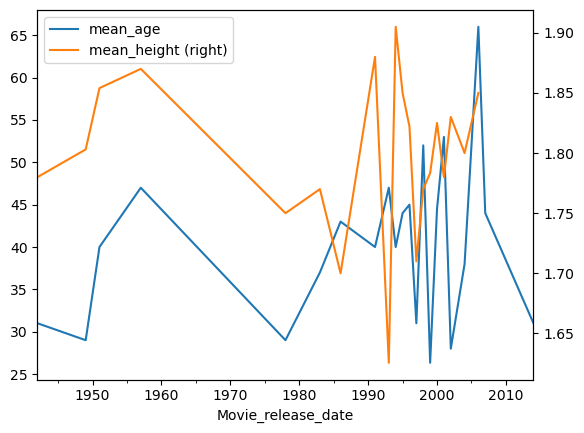

In [36]:
b.mean_age.plot(grid=True, label="mean_age", legend=True)
b.mean_height.plot(secondary_y=True, label="mean_height", legend=True)

<AxesSubplot:>

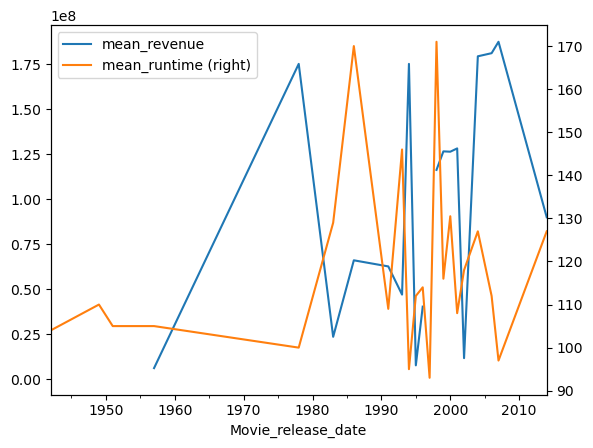

In [37]:
b.mean_revenue.plot(grid=True, label="mean_revenue", legend=True)
b.mean_runtime.plot(secondary_y=True, label="mean_runtime", legend=True)

In [60]:
Crazy_jalouse_guy.Actor_Ethnicity.value_counts() #mostly american

Italian Americans         4
Scottish American         2
English people            2
Māori                     1
Scotch-Irish Americans    1
German Americans          1
Kiwi                      1
Swedish Americans         1
Jewish people             1
Irish people              1
Danish Americans          1
British people            1
Name: Actor_Ethnicity, dtype: int64

In [66]:
Crazy_jalouse_guy.movie.is_unique

True

In [ ]:
sns.regplot(x='Age_at_movie_release', y='Actor_Gender', data=Crazy_jalouse_guy, logistic=True, ci=None)